In [87]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torchvision
import torchvision.transforms as transforms
from pytorch_lightning import Trainer
import torch.nn as nn
import torch
import torch.nn.functional as F
import albumentations.pytorch as A
from torch.utils.data import DataLoader
from albumentations import Resize, PadIfNeeded, Compose, Normalize, LongestMaxSize
from torch.utils.data import Dataset
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import train_test_split
from skimage.transform import rotate, AffineTransform, warp
from tqdm.auto import tqdm
from pytorch_lightning import LightningModule, Trainer
from sklearn.metrics import mean_absolute_percentage_error
from torchvision.transforms.functional import to_pil_image
from torch import optim
from PIL import Image

### Пункт 1

In [3]:
def shift_image(image_path, interpolation=cv2.INTER_CUBIC):
    image = cv2.imread(image_path)

    if image is None:
        print(f"Unable to open image at {image_path}")
        return None

    matrix = np.float32([[1, 0, 3.5], [0, 1, 3.5]])
    shifted = cv2.warpAffine(image, matrix, (image.shape[1], image.shape[0]), 
                             flags=interpolation, borderMode=cv2.BORDER_WRAP)

    return shifted


In [4]:
def process_images(src_dir, target_dir):
    if not os.path.isdir(src_dir):
        print(f"{src_dir} is not a directory")
        return

    os.makedirs(target_dir, exist_ok=True)

    image_paths = [os.path.join(src_dir, img) for img in os.listdir(src_dir) 
                   if os.path.isfile(os.path.join(src_dir, img))]

    for img_path in image_paths:
        shifted = shift_image(img_path)
        if shifted is not None:
            cv2.imwrite(os.path.join(target_dir, os.path.basename(img_path)), shifted)
    
    print(f"All images have been successfully shifted and saved in {target_dir}")


Наивный тест функций

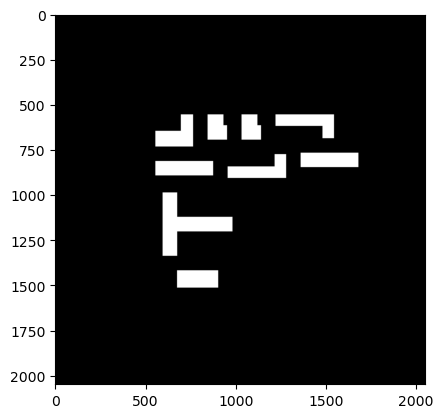

In [5]:
img_path = "/kaggle/input/data-wb/dataset/src/100_0.png"
sh_im = shift_image(img_path)
plt.imshow(cv2.cvtColor(sh_im, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
#process_images(src_dir=r"C:\Users\User\Downloads\dataset\dataset\src", target_dir=r"C:\Users\User\Downloads\dataset\dataset\dst")

### Пункт 2

In [7]:
def create_dataset(src_dir, dst_dir, test_size=0.2):
    src_image_paths = [os.path.join(src_dir, img) for img in os.listdir(src_dir) 
                       if os.path.isfile(os.path.join(src_dir, img))]
    dst_image_paths = [os.path.join(dst_dir, img) for img in os.listdir(dst_dir) 
                       if os.path.isfile(os.path.join(dst_dir, img))]

    if len(src_image_paths) != len(dst_image_paths):
        print("The number of images in src_dir does not match the number of images in dst_dir")
        return

    image_pairs = list(zip(src_image_paths, dst_image_paths))
    train_pairs, test_pairs = train_test_split(image_pairs, test_size=test_size)

    return train_pairs, test_pairs


In [8]:
data = create_dataset(
    src_dir="/kaggle/input/data-wb/dataset/src",
    dst_dir="/kaggle/input/data-wb/dataset/dst"
)

In [9]:
class PairedImageDataset(Dataset):
    def __init__(self, image_pairs, transform=None):
        self.image_pairs = image_pairs
        self.transform = transform

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        img_name1, img_name2 = self.image_pairs[idx]

        image1 = cv2.imread(img_name1)
        image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
        image1 = image1.astype(np.float32) / 255.0

        image2 = cv2.imread(img_name2)
        image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
        image2 = image2.astype(np.float32) / 255.0

        if self.transform:
            image1 = self.transform(image=image1)["image"]
            image2 = self.transform(image=image2)["image"]

        return image1, image2


In [10]:
torch.cuda.empty_cache()

### Пункты 3-4

In [19]:
import os
transform = Compose([
    LongestMaxSize(max_size=224),
    PadIfNeeded(min_height=224, min_width=224, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),
    ToTensorV2(),
])

train_data, test_data = create_dataset(
    src_dir="/kaggle/input/data-wb/dataset/src",
    dst_dir="/kaggle/input/data-wb/dataset/dst"
)

train_dataset = PairedImageDataset(train_data, transform=transform)
test_dataset = PairedImageDataset(test_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [21]:
class ShiftNet(LightningModule):
    def __init__(self):
        super(ShiftNet, self).__init__()
        self.conv = nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1, bias=False)

        self.conv.weight.data.fill_(0) 
        self.conv.weight.data[:, :, 1, 1] = 1 # Инициализация ядра свертки так, чтобы оно представляло собой матрицу смещения
        self.loss = nn.MSELoss()

    def forward(self, x):
        return self.conv(x)

    def training_step(self, batch, batch_idx):
        src_imgs, tgt_imgs = batch
        src_imgs = src_imgs.to(device)
        tgt_imgs = tgt_imgs.to(device)
        output = self(src_imgs)
        loss = self.loss(output, tgt_imgs)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        src_imgs, tgt_imgs = batch
        src_imgs = src_imgs.to(device)
        tgt_imgs = tgt_imgs.to(device)
        output = self(src_imgs)
        loss = self.loss(output, tgt_imgs)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        tgt_imgs_np = tgt_imgs.cpu().detach().numpy()
        output_np = output.cpu().detach().numpy()

        mape = mean_absolute_percentage_error(tgt_imgs_np.flatten(), output_np.flatten())

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

model = ShiftNet()
trainer = Trainer(max_epochs=100)
trainer.fit(model, train_loader, val_loader)


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

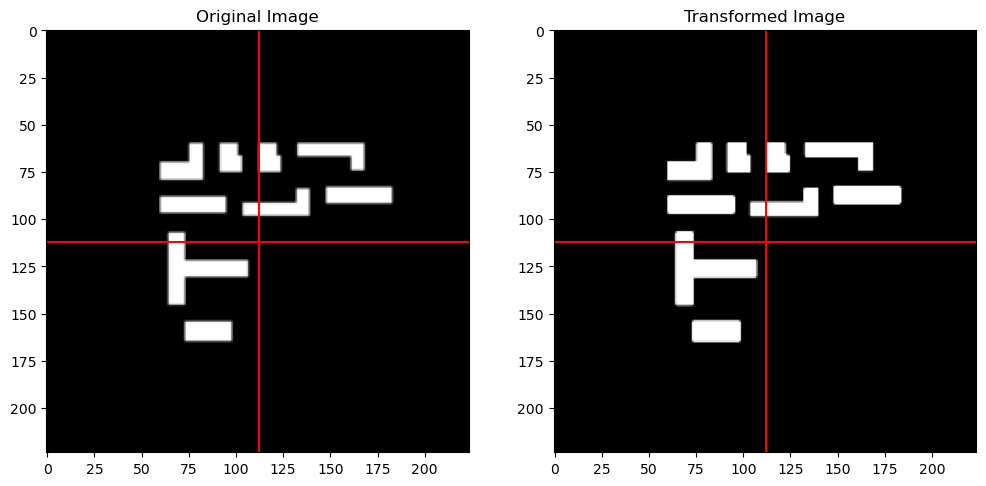

In [102]:
img_path = "/kaggle/input/data-wb/dataset/src/100_0.png"
image = Image.open(img_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

image_tensor = transform(image).unsqueeze(0).to(device)

shiftnet_model = ShiftNet() 
shiftnet_model = shiftnet_model.to(device)
shiftnet_model.eval() 

with torch.no_grad():
    transformed_image_tensor = shiftnet_model(image_tensor)

image_display = image_tensor.squeeze().cpu().permute(1, 2, 0).numpy()
transformed_image_display = transformed_image_tensor.squeeze().cpu().permute(1, 2, 0).numpy()

image_shift_ = Image.open("/kaggle/input/data-wb/dataset/dst/100_0.png").convert('RGB')
image_tensor_ = transform(image_shift_).unsqueeze(0).to(device)
image_shift = image_tensor_.squeeze().cpu().permute(1, 2, 0).numpy()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image_display)
ax[0].axhline(image_display.shape[0] / 2, color='r')
ax[0].axvline(image_display.shape[1] / 2, color='r')
ax[0].set_title("Original Image")

ax[1].imshow(transformed_image_display)
ax[1].axhline(transformed_image_display.shape[0] / 2, color='r')
ax[1].axvline(transformed_image_display.shape[1] / 2, color='r')
ax[1].set_title("Transformed Image")

# Отобразите фигуру
plt.show()


In [59]:
import cv2
import numpy as np

def calculate_shift_error(image1, image2):
    gray1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

    # Вычислим оптический поток
    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None,
                                        0.5, 3, 15, 3, 5, 1.2, 0)
    
    shift_error_x = np.mean(np.abs(flow[..., 0])) # Вычислим ошибку сдвига как среднее абсолютное значение оптического потока по соответствующим осям
    shift_error_y = np.mean(np.abs(flow[..., 1]))

    return shift_error_x, shift_error_y


shift_error_x, shift_error_y = calculate_shift_error(image_shift, transformed_image_display)
print(f"Shift X error: {shift_error_x * 2048 / 224}, Shift Y error: {shift_error_y * 2048 / 224} ")

Shift X error: 0.0016981499003512518, Shift Y error: 0.0016449338623455592 


In [60]:
shift_error_x, shift_error_y = calculate_shift_error(image_shift, image_display)
print(f"Shift X error: {shift_error_x * 2048 / 224}, Shift Y error: {shift_error_y * 2048 / 224} ")

Shift X error: 0.00010268925689160824, Shift Y error: 0.00010275309406487005 


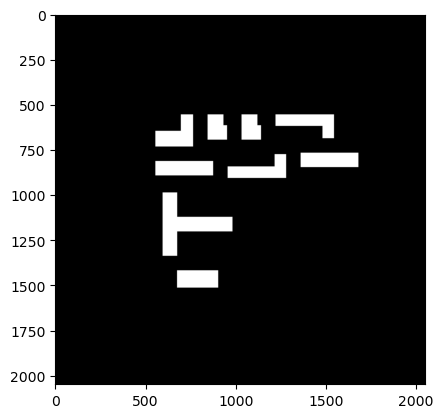

In [31]:
plt.imshow(image_shift_)

In [83]:
@torch.no_grad()
def calculate_and_plot_shift_errors(model, transform, data):
    errors_x = []
    errors_y = []
    model.eval()

    for img_src_path, img_dst_path in data:
        image = Image.open(img_src_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)

        transformed_image_tensor = model(image_tensor)

        image_display = image_tensor.squeeze().cpu().permute(1, 2, 0).numpy()
        transformed_image_display = transformed_image_tensor.squeeze().cpu().permute(1, 2, 0).numpy()

        image_shift = Image.open(img_dst_path).convert('RGB')
        image_shift_tensor = transform(image_shift).unsqueeze(0).to(device)
        image_shift_display = image_shift_tensor.squeeze().cpu().permute(1, 2, 0).numpy()

        shift_error_x, shift_error_y = calculate_shift_error(image_shift_display, transformed_image_display)
        errors_x.append(shift_error_x * 2048 / 224)
        errors_y.append(shift_error_y * 2048 / 224)

    # Построение гистограммы ошибок сдвига
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(errors_x, bins=50, color='blue', alpha=0.7)
    plt.title('Histogram of Shift X Errors')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    plt.hist(errors_y, bins=50, color='red', alpha=0.7)
    plt.title('Histogram of Shift Y Errors')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


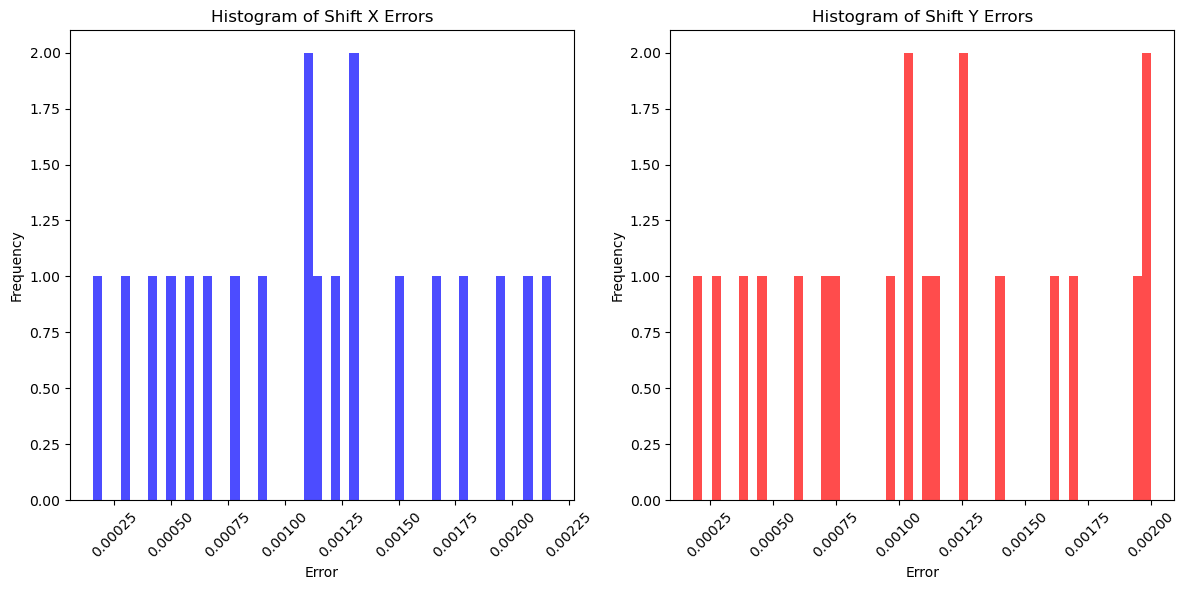

In [85]:
shiftnet_model = ShiftNet()
shiftnet_model = shiftnet_model.to(device)
shiftnet_model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

calculate_and_plot_shift_errors(shiftnet_model, transform, data[1])

In [88]:
class Net(nn.Module): # реализация модели stn для преобразований изображения
    def __init__(self):
        super(Net, self).__init__()

        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        self.fc_loc = nn.Sequential(
            nn.Linear(27040, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        
        self.fc_loc[2].weight.data.zero_() 
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float)) # Инициализация весов тождественного преобразования

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 27040)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        x = self.stn(x)
        return x

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Net().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [90]:
import pytorch_lightning as pl

class ShiftNetModule(pl.LightningModule):
    def __init__(self):
        super(ShiftNetModule, self).__init__()
        self.model = Net() 
        self.criterion = torch.nn.MSELoss() 

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        data, target = batch
        output = self.model(data)
        loss = self.criterion(output, target)

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        data, target = batch
        output = self.model(data)
        loss = self.criterion(output, target)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001) 
        return optimizer


In [92]:
model = ShiftNetModule()
trainer = Trainer(max_epochs=16)

# Обучение модели
trainer.fit(model, train_loader, val_loader)

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Пункт 5

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


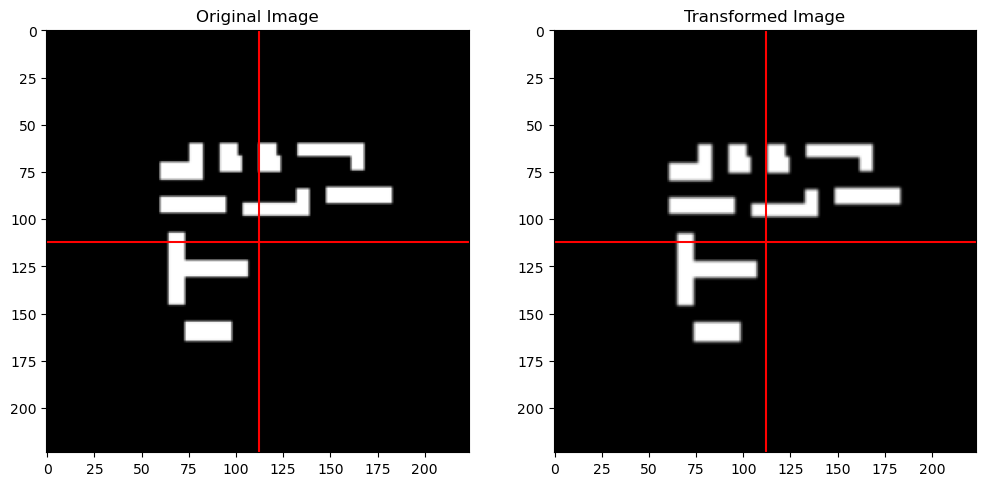

In [103]:
from PIL import Image
import torchvision.transforms as transforms

image = Image.open(img_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
image_tensor = transform(image).unsqueeze(0).to(device)

model.to(device)
model.eval()
with torch.no_grad():
    transformed_image_tensor = model(image_tensor)

image_display = image_tensor.squeeze().cpu().permute(1, 2, 0).numpy()
transformed_image_display = transformed_image_tensor.squeeze().cpu().permute(1, 2, 0).numpy()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image_display)
ax[0].axhline(image_display.shape[0] / 2, color='r')
ax[0].axvline(image_display.shape[1] / 2, color='r')
ax[0].set_title("Original Image")

ax[1].imshow(transformed_image_display)
ax[1].axhline(transformed_image_display.shape[0] / 2, color='r')
ax[1].axvline(transformed_image_display.shape[1] / 2, color='r')
ax[1].set_title("Transformed Image")

plt.show()


In [106]:
# Пример использования
shift_error_x, shift_error_y = calculate_shift_error(image_shift, transformed_image_display)
print(f"Shift X error: {shift_error_x}, Shift Y error: {shift_error_y} ")


Shift X error: 2.0210145521559753e-06, Shift Y error: 3.528108663886087e-06 


In [105]:
shift_error_x, shift_error_y = calculate_shift_error(image_shift, image_display)
print(f"Shift X error: {shift_error_x * 2048 / 224}, Shift Y error: {shift_error_y * 2048 / 224} ")

Shift X error: 0.00010268925689160824, Shift Y error: 0.00010275309406487005 


/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


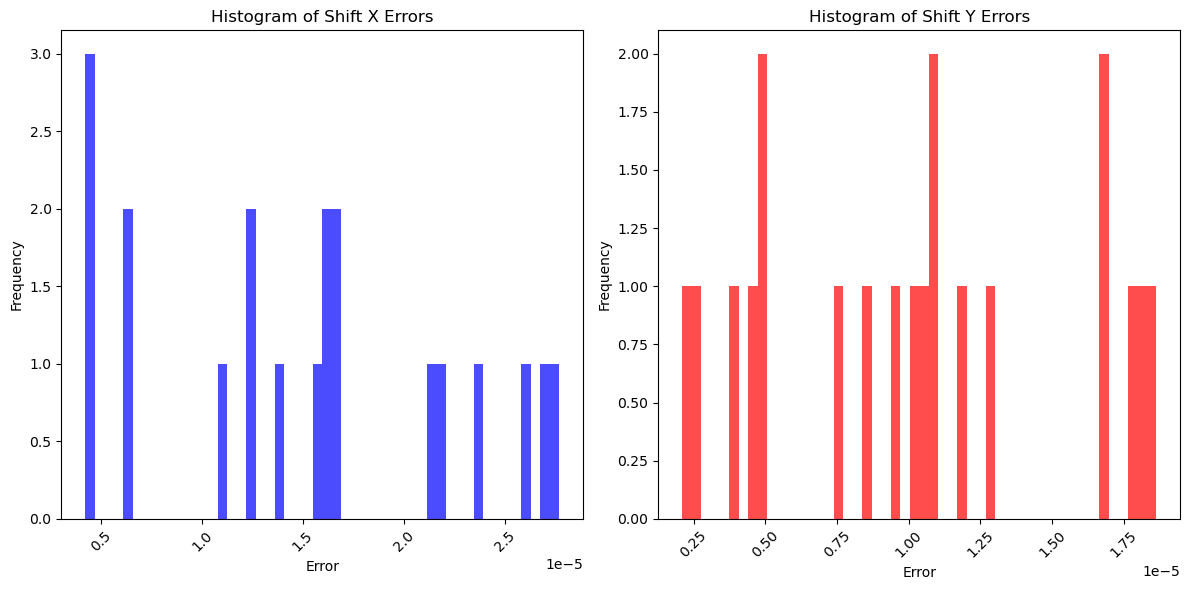

In [86]:
calculate_and_plot_shift_errors(model, transform, data[1])